In [18]:
from dataclasses import dataclass
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
import scipy

In [19]:
sns.set_theme(style="whitegrid")

ASSIGNMENT_PATH = Path().resolve().parent
DATA_PATH = ASSIGNMENT_PATH / "data"
OUTPUT_PATH = ASSIGNMENT_PATH / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
EXPORT_DPI = 600
assert DATA_PATH.exists()

In [20]:
@dataclass
class ModelParams:
    p: int
    d: int
    q: int
    P: int
    D: int
    Q: int
    s: int

    phis: list[float]
    Phis: list[float]
    thetas: list[float]
    Thetas: list[float]

    var: float

    def to_params(self):
        """
        Convert the model parameters to a list of parameters for the SARIMAX model.
        """
        params = []
        params.extend(self.phis)
        params.extend(self.thetas)
        params.extend(self.Phis)
        params.extend(self.Thetas)
        params.append(self.var)

        assert len(params) == self.p + self.q + self.P + self.Q + 1
        return params

    def to_model(self, endog=None):
        pdq = (self.p, self.d, self.q)
        seasonal_PDQs = (self.P, self.D, self.Q, self.s)

        if endog is None:
            endog = []

        return SARIMAX(
            endog,
            order=pdq,
            seasonal_order=seasonal_PDQs,
        )

    @classmethod
    def from_weights(
        cls,
        phis: list[float] | None = None,
        thetas: list[float] | None = None,
        Phis: list[float] | None = None,
        Thetas: list[float] | None = None,
        d: int = 0,
        D: int = 0,
        s: int = 0,
        var: float = 1.0,
    ):
        """
        Create a ModelParameters instance from a list of parameters.
        """
        if phis is None:
            phis = []
        if thetas is None:
            thetas = []
        if Phis is None:
            Phis = []
        if Thetas is None:
            Thetas = []

        p = len(phis)
        q = len(thetas)
        P = len(Phis)
        Q = len(Thetas)

        return cls(
            p=p,
            d=d,
            q=q,
            P=P,
            D=D,
            Q=Q,
            s=s,
            phis=phis,
            Phis=Phis,
            thetas=thetas,
            Thetas=Thetas,
            var=var,
        )


def plotter(df, params, *, title, n_lags=30):
    """
    Plot the simulated data from a SARIMAX model using a 2-column layout.

    Parameters:
    - model: SARIMAX model instance
    - params: list of parameters for the model
    - n: number of observations to simulate
    - title: title for the overall figure
    """
    # Create a 2×1+1×2 subplot layout
    fig, axes = plt.subplot_mosaic([["ts", "ts"], ["acf", "pacf"]], figsize=(10, 5))

    param_desc = f"(p, d, q) = ({params.p}, {params.d}, {params.q})"
    param_desc += (
        f"\\quad (P, D, Q)_s = ({params.P}, {params.D}, {params.Q})_{{{params.s}}}"
    )
    weights = []
    weights.extend([f"ϕ_{i + 1} = {params.phis[i]}" for i in range(0, params.p)])
    weights.extend([f"θ_{i + 1} = {params.thetas[i]}" for i in range(0, params.q)])
    weights.extend([f"Φ_{i + 1} = {params.Phis[i]}" for i in range(0, params.P)])
    weights.extend([f"Θ_{i + 1} = {params.Thetas[i]}" for i in range(0, params.Q)])
    weights.append(f"σ^2 = {params.var}")

    param_desc += f"\\quad {', '.join(weights)}"
    param_desc = "$" + param_desc + "$"
    title += "\n" + param_desc
    fig.suptitle(title, fontsize=14)

    # Time series
    sns.lineplot(df, x="t", y="y", ax=axes["ts"])
    # axes["ts"].set_title("Time Series")
    axes["ts"].set_xlabel("Discretised Time, $t$")
    axes["ts"].set_ylabel("Observation, $y_t$")

    # ACF plot
    plot_acf(df["y"], lags=n_lags, ax=axes["acf"], alpha=0.05, auto_ylims=True)
    axes["acf"].set_title("Autocorrelation")
    axes["acf"].set_xlabel("Lag, $k$")
    axes["acf"].set_ylabel("$ρ(k)$")

    # PACF plot
    plot_pacf(
        df["y"], lags=n_lags, ax=axes["pacf"], alpha=0.05, zero=False, auto_ylims=True
    )
    axes["pacf"].set_title("Partial Autocorrelation")
    axes["pacf"].set_xlabel("Lag, $k$")
    axes["pacf"].set_ylabel("$φ(k)$")

    plt.tight_layout()
    plt.subplots_adjust(top=0.87)  # Make room for the title
    return fig, axes


def make_data(params, n=1000, burn_in=1000, rng_seed: int = 0):
    """
    Create a SARIMAX model and simulate data.
    """

    model = params.to_model()
    # print(model.param_names)

    # Simulate data
    t = np.arange(n)
    rng = np.random.default_rng(rng_seed)
    y = model.simulate(params.to_params(), n + burn_in, random_state=rng)[burn_in:]

    return pd.DataFrame({"y": y, "t": t})


def make_and_plot(params, n=1000, title="SARIMAX Model Simulation", n_lags=30):
    """
    Create and plot a SARIMAX model with the given parameters.
    """
    df = make_data(params, n)
    fig, axes = plotter(df, params, title=title, n_lags=n_lags)
    return fig
    # plt.savefig(OUTPUT_DIR / f"1_4_{pdq}_{seasonal_PDQs}.png", dpi=DPI_EXPORT)


In [21]:
# Again, parameter signs are swapped
phi_1 = -0.38
Phi_1 = -0.94

phi_1_sarimax = - phi_1
Phi_1_sarimax = - Phi_1
mu = 5.72
s = 12
var = 0.22**2


params = ModelParams.from_weights(
    phis=[phi_1_sarimax],
    Phis=[Phi_1_sarimax],
    s=12,
    var=var,
)


In [22]:
df = pd.read_csv(DATA_PATH / "datasolar.csv")
df["Y_t"] = df["power"]
df["X_t"] = np.log(df["Y_t"]) - mu

In [23]:
# # This does an actual fit! Not what question asks about!

# model = params.to_model(endog=df["X_t"])
# model_fit = model.fit(disp=0)
# model_fit.summary()

# fig = plt.figure(figsize=(10, 4))
# model_fit.plot_diagnostics(fig=fig)
# plt.tight_layout()

# residuals = model_fit.resid
# print(np.mean(residuals))

# plt.suptitle("Residual Analysis", y=1.02)
# plt.savefig(OUTPUT_PATH / "2_residual_analysis.png", dpi=EXPORT_DPI, bbox_inches="tight")

0.02309495836212152


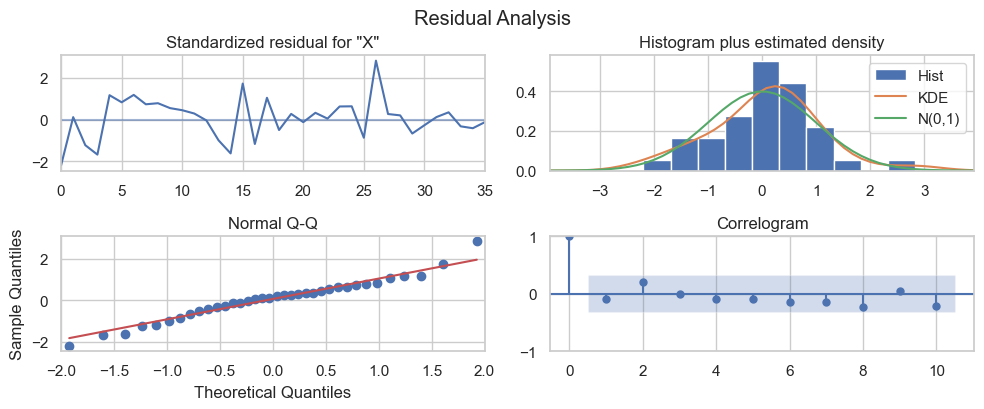

In [24]:
model = params.to_model(endog=df["X_t"])

# This is a bit of a hack to construct a result class without actually fitting anything
# There is probably a better way of doing this, but the statsmodel documentation is
# a bit lacking in this respect, and this should work just fine
params_dict = dict(zip(model.param_names, params.to_params()))
with model.fix_params(params_dict):
    model_fit = model.fit()

# model.predict(params=params.to_params())
# model_fit = model.fit(disp=0)
model_fit.summary()


fig = plt.figure(figsize=(10, 4))
model_fit.plot_diagnostics(fig=fig)
plt.tight_layout()

residuals = model_fit.resid
print(np.mean(residuals))

plt.suptitle("Residual Analysis", y=1.02)
plt.savefig(OUTPUT_PATH / "2_residual_analysis.png", dpi=EXPORT_DPI, bbox_inches="tight")

## 2.2 - Forecasting

In [25]:
model_fit.forecast(steps=12)

df_forecast = pd.DataFrame({"X_t": model_fit.forecast(steps=12)})
df_forecast["Y_t"] = np.exp(df_forecast["X_t"] + mu)
df_forecast["Type"] = "Forecast"
df_forecast["year"] = 2011
df_forecast["month"] = np.arange(1, 13)
df_forecast["k"] = np.arange(1, 13)
df["Type"] = "Observed"
df = pd.concat([df, df_forecast])
df["k"] = df.index - 35
df["time"] = pd.to_datetime(df[["year", "month"]].assign(day=1))

def rounder(x):
    return f"{x:.2f}"

df_present = df.query("Type == 'Forecast'")[["time", "Y_t", "X_t"]].copy()
df_present["X_t"] = df_present["X_t"].apply(rounder)
df_present["Y_t"] = df_present["Y_t"].apply(rounder)
df_present.rename(columns={
    "time": "Time",
    "Y_t": "Y_t (Power) [MWh]",
}, inplace=True)



df_present.to_csv(OUTPUT_PATH / "2_2.csv", index=False)

In [26]:
df

,year,month,power,Y_t,X_t,Type,k,time
0,2008,1,66.0,66.000000,-1.530345,Observed,-35,2008-01-01
1,2008,2,184.0,184.000000,-0.505064,Observed,-34,2008-02-01
2,2008,3,114.0,114.000000,-0.983802,Observed,-33,2008-03-01
3,2008,4,71.0,71.000000,-1.457320,Observed,-32,2008-04-01
4,2008,5,373.0,373.000000,0.201578,Observed,-31,2008-05-01
5,2008,6,562.0,562.000000,0.611502,Observed,-30,2008-06-01
6,2008,7,824.0,824.000000,0.994171,Observed,-29,2008-07-01
7,2008,8,708.0,708.000000,0.842444,Observed,-28,2008-08-01
8,2008,9,680.0,680.000000,0.802093,Observed,-27,2008-09-01
9,2008,10,551.0,551.000000,0.591735,Observed,-26,2008-10-01


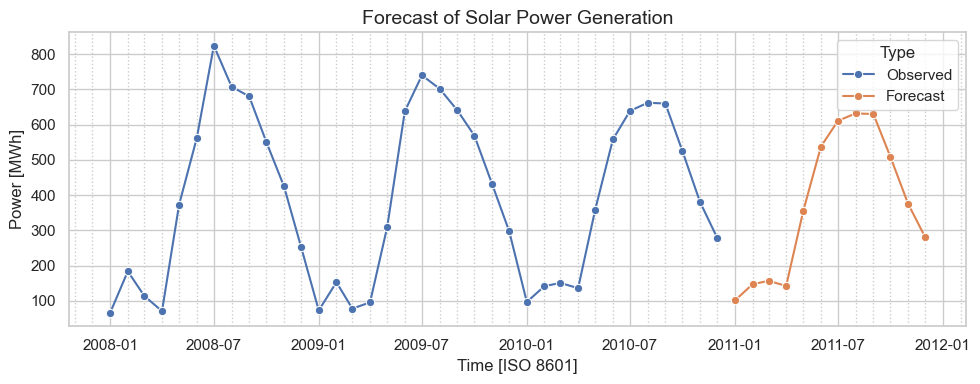

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(df, x="time", y="Y_t", hue="Type", ax=ax, marker="o")

plt.title("Forecast of Solar Power Generation", fontsize=14)
plt.xlabel("Time [ISO 8601]")
plt.ylabel("Power [MWh]")
plt.tight_layout()

ax.get_xaxis().set_minor_locator(mpl.dates.MonthLocator())
plt.grid(which="minor", linestyle=":")
plt.savefig(
    OUTPUT_PATH / "2_2_forecast.png",
    dpi=EXPORT_DPI,
    bbox_inches="tight",
)

# df


In [28]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                X_t   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                  -8.837
Date:                            Mon, 21 Apr 2025   AIC                             17.673
Time:                                    12:21:27   BIC                             17.673
Sample:                                         0   HQIC                            17.673
                                             - 36                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1 (fixed)        0.3800        nan        nan        nan         nan         nan
ar.S.L12 (fixed)     0.9400        nan        nan        nan         nan         nan
sigma2 (fixed)       0.0484        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.56   Prob(JB):                         0.66
Heteroskedasticity (H):               0.71   Skew:                             0.08
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 2.3 Prediction Interval


In [29]:
alpha = 0.05
u_alpha2 = scipy.stats.norm.ppf(1 - alpha/2)

sigma_epsilon = np.sqrt(var)

def weights(k):
    assert k <= 23
    weight = 0
    weight += (-phi_1)**k
    if k >= 12:
        weight += -Phi_1 * (-phi_1)**(k - 12)

    return weight

def sigma_k_factor(k):
    s = 1
    for sk in range(1, k + 1):
        s += weights(sk)**2

    return np.sqrt(s)

# sigma_k_factor(1)

def prediction_error(k):
    if k <= 0:
        return None
    return u_alpha2 * sigma_epsilon * sigma_k_factor(k)


In [30]:
df

,year,month,power,Y_t,X_t,Type,k,time
0,2008,1,66.0,66.000000,-1.530345,Observed,-35,2008-01-01
1,2008,2,184.0,184.000000,-0.505064,Observed,-34,2008-02-01
2,2008,3,114.0,114.000000,-0.983802,Observed,-33,2008-03-01
3,2008,4,71.0,71.000000,-1.457320,Observed,-32,2008-04-01
4,2008,5,373.0,373.000000,0.201578,Observed,-31,2008-05-01
5,2008,6,562.0,562.000000,0.611502,Observed,-30,2008-06-01
6,2008,7,824.0,824.000000,0.994171,Observed,-29,2008-07-01
7,2008,8,708.0,708.000000,0.842444,Observed,-28,2008-08-01
8,2008,9,680.0,680.000000,0.802093,Observed,-27,2008-09-01
9,2008,10,551.0,551.000000,0.591735,Observed,-26,2008-10-01


In [31]:
df["prediction_error"] = df["k"].apply(prediction_error)

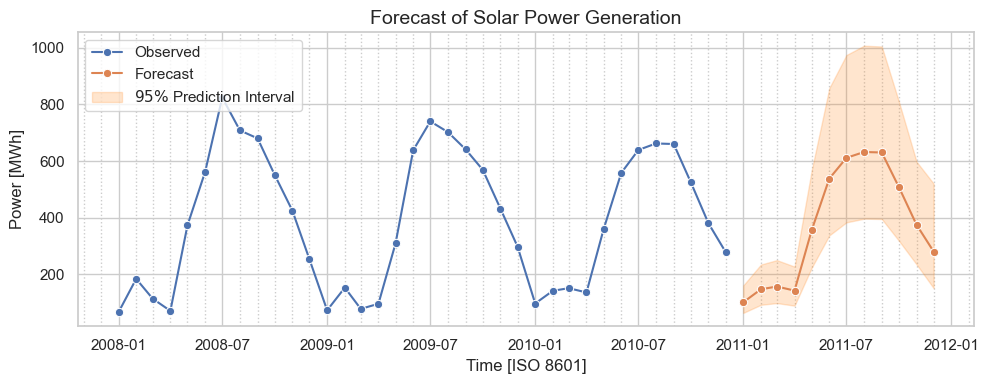

In [32]:
# Plot
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(df, x="time", y="Y_t", hue="Type", ax=ax, marker="o")

plt.title("Forecast of Solar Power Generation", fontsize=14)
plt.xlabel("Time [ISO 8601]")
plt.ylabel("Power [MWh]")
plt.tight_layout()

ax.get_xaxis().set_minor_locator(mpl.dates.MonthLocator())
plt.grid(which="minor", linestyle=":")
plt.savefig(
    OUTPUT_PATH / "2_2_forecast.png",
    dpi=EXPORT_DPI,
    bbox_inches="tight",
)

df_predict = df.copy()
df_predict["X_t_lower"] = df_predict["X_t"] - df_predict["prediction_error"]
df_predict["X_t_upper"] = df_predict["X_t"] + df_predict["prediction_error"]
df_predict["Y_t_lower"] = np.exp(df_predict["X_t_lower"] + mu)
df_predict["Y_t_upper"] = np.exp(df_predict["X_t_upper"] + mu)


plt.fill_between(
    df_predict["time"],
    df_predict["Y_t_lower"],
    df_predict["Y_t_upper"],
    color="tab:orange",
    alpha=0.2,
    label="$95\\%$ Prediction Interval",
)

plt.legend(loc="upper left")

plt.savefig(
    OUTPUT_PATH / "2_3_forecast_ci.png",
    dpi=EXPORT_DPI,
    bbox_inches="tight",
)
